In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from pyod.models.knn import KNN
from sklearn.cluster import KMeans
import seaborn as sns
from datetime import datetime, timedelta
import csv
from scipy import stats
import scipy as sp
from scipy.signal import correlate
from six.moves import cPickle as pickle
import pickle as _pickle
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import os
import padasip as pa


## Importando dados

Aqui foram criados dataframes de vários arquivos, cada arquivo corresponde a uma linha de onibus

In [112]:
# função criar dataframe
def createPkl(link):    
#     importa o arquivo pkl
    df = pd.read_pickle('../data/linktt/'+'link-'+link+'.pkl')
#     exclui colunas
#     df = df.drop(['_id', 'hour', 'link', 'trip_id', 'travel_id', 'month', 'weekday'], axis=1)
    df = df.drop(['_id', 'travel_id', 'weekday'], axis=1)
#     renomeia coluna ltt pelo nome do link
#     df = df.rename(columns={"ltt": name})
    return df

### Prieira vizualização dos dados.
foram removidas colunas que não tem serventia como mes e dia da semana, já que a coluna aproxlinkstart possui os dados completos de dia mes hora ano. O dataset possui 977.524 linhas de entradas de dados, restaram as colunas:

aproxlinkstart - data e hora

hour - hora

link - trecho da linha de onibus

ltt - tempo de viagem

trip_id - código da linha

In [113]:
# Importa lista com links
all_links = pd.read_csv('../data/linktt/links.txt', sep='\n')
# renomeia a coluna que foi criada com o nome do primero link para all_links
all_links = all_links.rename(columns={"(576, 577)": "all_links"})
# cria um dataframe dataset_pkl
dataset_pkl = pd.DataFrame()
# Concatena todos os links
for link in all_links['all_links']:
    df = createPkl(link)
    dataset_pkl = pd.concat([dataset_pkl, df], sort=True)


dataset_pkl
# Prieira vizualização dos dados, foram retiradas colnas que não tem serventia como mes e dia da semana, 
# já que a coluna aproxlinkstart possui os dados completos de dia mes hora ano 
# o dataset possui 977.524 linhas de entradas de dados

,aproxlinkstart,hour,link,ltt,month,trip_id
0,2017-01-02 06:26:46.054,6,"(577, 578)",192.242289,1,6475-10-0
1,2017-01-02 06:57:03.961,6,"(577, 578)",286.324701,1,6475-10-0
2,2017-01-02 07:03:42.030,7,"(577, 578)",519.623291,1,6475-10-0
3,2017-01-02 07:24:18.127,7,"(577, 578)",444.353503,1,6475-10-0
4,2017-01-02 07:40:59.560,7,"(577, 578)",682.389588,1,6475-10-0
...,...,...,...,...,...,...
7860,2017-09-29 21:04:53.677,21,"(795, 796)",107.890092,9,2080-10-0
7861,2017-09-29 21:32:17.581,21,"(795, 796)",85.350079,9,2080-10-0
7862,2017-09-29 21:41:39.458,21,"(795, 796)",89.538335,9,2080-10-0
7863,2017-09-29 22:10:03.770,22,"(795, 796)",61.377175,9,2080-10-0


In [114]:
df

,aproxlinkstart,hour,link,ltt,month,trip_id
0,2017-01-02 06:05:51.502,6,"(795, 796)",65.785448,1,2080-10-0
1,2017-01-02 06:47:00.649,6,"(795, 796)",86.222480,1,2080-10-0
2,2017-01-02 07:06:55.540,7,"(795, 796)",107.565144,1,2080-10-0
3,2017-01-02 07:33:45.041,7,"(795, 796)",72.732072,1,2080-10-0
4,2017-01-02 08:22:08.592,8,"(795, 796)",118.231885,1,2080-10-0
...,...,...,...,...,...,...
7860,2017-09-29 21:04:53.677,21,"(795, 796)",107.890092,9,2080-10-0
7861,2017-09-29 21:32:17.581,21,"(795, 796)",85.350079,9,2080-10-0
7862,2017-09-29 21:41:39.458,21,"(795, 796)",89.538335,9,2080-10-0
7863,2017-09-29 22:10:03.770,22,"(795, 796)",61.377175,9,2080-10-0


## Criando um timestamp
um timestamp é uma medida de tempo unix, um numero unico que marca cada hora, mostrando um valor relativo a cada hora, uma forma de medir uma valor interativo de horas.

Foi introduzida uma coluna time_stamp_start, contendo o valor de hora transformado.

In [115]:
# função tranforma a hora do datetime
def hr_func(ts):
    return ts.hour
# Cria uma coluna com dias
dataset_pkl['day'] = [d.day for d in dataset_pkl['aproxlinkstart']]
# Cria uma coluna com as horas
dataset_pkl['day_hour'] = dataset_pkl['aproxlinkstart'].apply(hr_func) #já tem a coluna hour
# Coloca a coluna aproxlinkstart com datetime como indice
dataset_pkl.index = dataset_pkl['aproxlinkstart']
# Cria uma coluna com timestamp
dataset_pkl['time_stamp_start'] = [d.timestamp() for d in dataset_pkl['aproxlinkstart']]

dataset_pkl

,aproxlinkstart,hour,link,ltt,month,trip_id,day,day_hour,time_stamp_start
aproxlinkstart,,,,,,,,,
2017-01-02 06:26:46.054,2017-01-02 06:26:46.054,6,"(577, 578)",192.242289,1,6475-10-0,2,6,1.483338e+09
2017-01-02 06:57:03.961,2017-01-02 06:57:03.961,6,"(577, 578)",286.324701,1,6475-10-0,2,6,1.483340e+09
2017-01-02 07:03:42.030,2017-01-02 07:03:42.030,7,"(577, 578)",519.623291,1,6475-10-0,2,7,1.483341e+09
2017-01-02 07:24:18.127,2017-01-02 07:24:18.127,7,"(577, 578)",444.353503,1,6475-10-0,2,7,1.483342e+09
2017-01-02 07:40:59.560,2017-01-02 07:40:59.560,7,"(577, 578)",682.389588,1,6475-10-0,2,7,1.483343e+09
...,...,...,...,...,...,...,...,...,...
2017-09-29 21:04:53.677,2017-09-29 21:04:53.677,21,"(795, 796)",107.890092,9,2080-10-0,29,21,1.506719e+09
2017-09-29 21:32:17.581,2017-09-29 21:32:17.581,21,"(795, 796)",85.350079,9,2080-10-0,29,21,1.506721e+09
2017-09-29 21:41:39.458,2017-09-29 21:41:39.458,21,"(795, 796)",89.538335,9,2080-10-0,29,21,1.506721e+09


{'whiskers': [<matplotlib.lines.Line2D at 0x7fe67947a160>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe6794adac8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe67946d0f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe6794ad780>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe6794ad9b0>],
 'means': []}

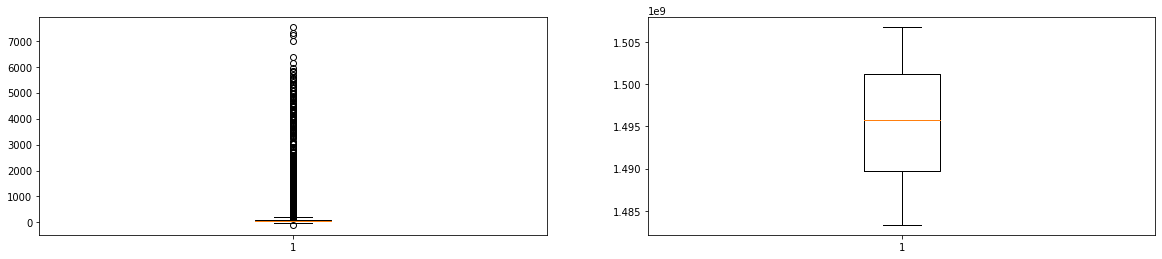

In [116]:
#  Detectando outliers
f, axarr = plt.subplots(1, 2, figsize=(20, 4))
axarr[0].boxplot(dataset_pkl["ltt"], showfliers=True)
axarr[1].boxplot(dataset_pkl["time_stamp_start"], showfliers=True)

##  Detectando outliers
Abaixo uma analise de outliers do tempo de viagem e do timestap que é uma medidade de tempo unix, existe muito valores inconsistentes no tempo de viagem (coluna ltt), enquanto o timestamp parecer estar bem mais equilibrado.


## outliers
Outro gráfico mostrando que, apesar de poucos, existem diversos valores conflitantes (outliers), etre 1000 e 7000 segundos de tempo de viagem.

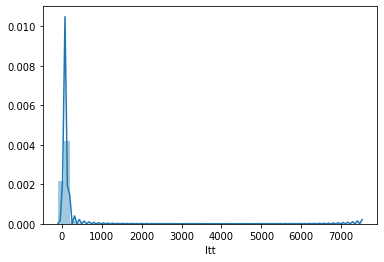

In [117]:
sns.distplot(dataset_pkl['ltt'])

# removendo outliers acima de 400

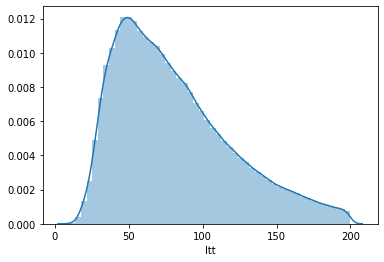

In [118]:
no_outlier = dataset_pkl[(dataset_pkl['ltt'] > 10) & (dataset_pkl['ltt'] < 200)]
sns.distplot(no_outlier['ltt'])


In [119]:
no_outlier

,aproxlinkstart,hour,link,ltt,month,trip_id,day,day_hour,time_stamp_start
aproxlinkstart,,,,,,,,,
2017-01-02 06:26:46.054,2017-01-02 06:26:46.054,6,"(577, 578)",192.242289,1,6475-10-0,2,6,1.483338e+09
2017-01-02 09:23:43.641,2017-01-02 09:23:43.641,9,"(577, 578)",195.993997,1,6475-10-0,2,9,1.483349e+09
2017-01-02 10:16:04.916,2017-01-02 10:16:04.916,10,"(577, 578)",147.412974,1,6475-10-0,2,10,1.483352e+09
2017-01-02 16:50:15.890,2017-01-02 16:50:15.890,16,"(577, 578)",111.722694,1,6475-10-0,2,16,1.483376e+09
2017-01-02 17:40:08.175,2017-01-02 17:40:08.175,17,"(577, 578)",121.659758,1,6475-10-0,2,17,1.483379e+09
...,...,...,...,...,...,...,...,...,...
2017-09-29 21:04:53.677,2017-09-29 21:04:53.677,21,"(795, 796)",107.890092,9,2080-10-0,29,21,1.506719e+09
2017-09-29 21:32:17.581,2017-09-29 21:32:17.581,21,"(795, 796)",85.350079,9,2080-10-0,29,21,1.506721e+09
2017-09-29 21:41:39.458,2017-09-29 21:41:39.458,21,"(795, 796)",89.538335,9,2080-10-0,29,21,1.506721e+09


In [120]:
no_outlier[(no_outlier.loc[:, 'link']=='(582, 17509)')]

,aproxlinkstart,hour,link,ltt,month,trip_id,day,day_hour,time_stamp_start
aproxlinkstart,,,,,,,,,
2017-02-02 07:45:24.370,2017-02-02 07:45:24.370,7,"(582, 17509)",111.261836,2,6450-51-0,2,7,1.486022e+09
2017-02-02 08:40:04.593,2017-02-02 08:40:04.593,8,"(582, 17509)",84.771613,2,6450-51-0,2,8,1.486025e+09
2017-02-03 07:03:46.251,2017-02-03 07:03:46.251,7,"(582, 17509)",98.002841,2,6450-51-0,3,7,1.486105e+09
2017-02-03 07:38:17.399,2017-02-03 07:38:17.399,7,"(582, 17509)",88.615017,2,6450-51-0,3,7,1.486107e+09
2017-02-14 06:53:55.341,2017-02-14 06:53:55.341,6,"(582, 17509)",92.225425,2,6450-51-0,14,6,1.487055e+09
...,...,...,...,...,...,...,...,...,...
2017-09-28 07:57:40.180,2017-09-28 07:57:40.180,7,"(582, 17509)",121.816373,9,6450-51-0,28,7,1.506585e+09
2017-09-28 08:57:14.348,2017-09-28 08:57:14.348,8,"(582, 17509)",94.368035,9,6450-51-0,28,8,1.506589e+09
2017-09-29 06:49:28.425,2017-09-29 06:49:28.425,6,"(582, 17509)",40.154106,9,6450-51-0,29,6,1.506668e+09


In [121]:
groupedData = no_outlier.groupby([pd.Grouper(freq='30min'), 'link'], sort=False)['ltt'].mean().unstack().reset_index()
groupedData_semNan = groupedData.dropna(thresh=40)
groupedData_semNan

link,aproxlinkstart,"(577, 578)","(578, 579)","(579, 580)","(580, 581)","(581, 582)","(582, 17509)","(582, 17779)","(582, 17933)","(583, 13761)",...,"(787, 788)","(788, 789)","(789, 790)","(790, 791)","(791, 792)","(792, 793)","(792, 4624)","(793, 794)","(794, 4750)","(795, 796)"
940,2017-03-14 06:30:00,164.841288,161.828455,142.193268,84.588066,65.878430,89.758715,96.018930,135.807690,191.675805,...,93.537890,61.180231,61.710855,52.652767,67.021601,64.292624,83.326048,31.649107,31.474190,123.576212
1055,2017-03-23 07:00:00,186.294350,134.052174,116.612505,100.532308,71.682190,85.699997,78.852401,114.400871,149.051569,...,81.104952,53.246584,64.584151,61.676708,65.163811,62.831694,65.675065,27.288692,35.754598,69.948899
1292,2017-04-12 09:00:00,175.400817,131.357179,128.739841,93.362338,71.973442,114.390053,93.949861,130.457196,151.012560,...,93.711378,57.230431,67.645138,48.295329,77.555394,78.976657,111.043142,123.717097,87.235232,77.831873
1463,2017-05-02 07:00:00,198.457496,198.805619,119.011776,101.846517,76.724128,105.042633,106.542519,139.470825,165.410981,...,116.034603,76.543509,53.743176,59.404358,65.966760,58.153932,97.370634,26.595281,33.608428,123.066609
1673,2017-05-19 07:00:00,150.194713,127.411692,149.667735,120.811128,94.443326,128.705337,100.255879,121.516073,126.315636,...,112.329691,72.705078,55.081954,59.475199,75.128612,57.837785,72.880610,30.529605,36.647232,126.098715
1815,2017-05-31 08:30:00,162.440694,135.111481,141.223843,89.509186,78.339454,70.293134,88.922189,189.328512,169.670573,...,110.894951,73.199912,51.212054,44.409720,71.797016,70.586417,128.826119,94.779333,78.541374,105.909134
2628,2017-07-31 06:30:00,154.067005,115.306408,125.861137,95.460753,67.170010,93.425082,85.144374,119.942799,195.658421,...,74.063354,73.419727,52.028871,43.548591,59.470889,41.586947,78.985740,28.710118,26.442012,102.562152
2773,2017-08-09 07:00:00,166.942292,133.353698,148.333080,110.592961,75.676073,89.861390,87.973451,125.247451,114.638629,...,81.265938,71.932965,60.785203,53.459168,66.809133,63.946772,72.910581,32.395293,25.822331,65.640345
3037,2017-09-01 07:00:00,176.170390,152.093092,139.730382,98.314256,71.595945,106.413777,86.876318,127.629844,166.240553,...,68.777959,58.971889,41.381014,58.956189,60.206703,47.569898,119.263784,34.005312,26.403831,78.059702
3255,2017-09-20 06:30:00,170.789282,98.579325,123.728009,82.780121,68.375802,81.506828,94.506644,93.609766,164.853451,...,115.398598,70.573150,50.021937,41.378530,56.799466,60.742014,62.986658,19.318733,23.574272,121.718712


In [122]:
no_outlier_577 = no_outlier.loc[(no_outlier['link'] == '(577, 578)')]
no_outlier_577 = no_outlier_577.drop(columns=['aproxlinkstart', 'hour', 'link', 'trip_id', 'day', 'time_stamp_start'])

In [123]:
no_outlier_577

,ltt,month,day_hour
aproxlinkstart,,,
2017-01-02 06:26:46.054,192.242289,1,6
2017-01-02 09:23:43.641,195.993997,1,9
2017-01-02 10:16:04.916,147.412974,1,10
2017-01-02 16:50:15.890,111.722694,1,16
2017-01-02 17:40:08.175,121.659758,1,17
...,...,...,...
2017-09-29 22:33:29.676,93.932277,9,22
2017-09-29 22:55:45.660,116.985658,9,22
2017-09-29 23:14:54.005,185.115917,9,23


In [124]:
#aqui é criado um dataframe como o no_outlier_577, mas com uma coluna day e sem a coluna aproxlinkstart

novo_dt = pd.DataFrame(no_outlier.loc[(no_outlier['link'] == '(577, 578)')])
novo_dt = novo_dt.drop(columns=['aproxlinkstart'])
novo_dt = novo_dt.reset_index()
novo_dt = novo_dt.drop(columns=['aproxlinkstart', 'time_stamp_start', 'trip_id', 'link', 'hour'])
novo_dt


,ltt,month,day,day_hour
0,192.242289,1,2,6
1,195.993997,1,2,9
2,147.412974,1,2,10
3,111.722694,1,2,16
4,121.659758,1,2,17
...,...,...,...,...
4591,93.932277,9,29,22
4592,116.985658,9,29,22
4593,185.115917,9,29,23
4594,121.544503,9,29,23


In [125]:
new_arr = []
for i in range(6, 24):
    new_arr.append(novo_dt.loc[(novo_dt.loc[:, 'day_hour'].values==i), 'ltt'].values)
new_arr

[array([192.24228928,  67.07246067, 114.55027099, 146.87635477,
        142.68083895, 135.64403262, 143.39382396, 147.55687938,
        144.05704758, 125.18432611, 148.46473393, 150.06189807,
        152.40985331, 152.03821594, 158.9500716 , 143.04263329,
        145.69660773,  99.59272852, 146.47170711,  34.42297661,
        148.99663181, 149.80967409, 156.99002401, 141.8096083 ,
        159.50293253,  74.29160759, 167.14474942, 138.64763871,
        171.58344541, 139.82103015, 179.1625589 , 167.62576737,
        142.5029949 , 128.79233085, 146.20706158, 183.3788303 ,
        191.59426152, 191.02846543, 146.55095219, 199.69175325,
        165.7545466 , 137.03913872, 163.34435824, 130.87065854,
        178.80827329, 126.38356716, 122.42019931, 179.51123831,
        157.70639981, 101.74081182, 188.097848  , 135.6620136 ,
        140.50796348, 174.14733592, 161.6367267 , 184.77283322,
        159.62785741, 146.58431453, 174.09053937, 181.81378617,
        141.41441987, 179.74411507, 139.

In [126]:
len(new_arr[0])

495

In [127]:
df_organizado = pd.DataFrame(new_arr)
df_organizado

,0,1,2,3,4,5,6,7,8,9,...,485,486,487,488,489,490,491,492,493,494
0,192.242289,67.072461,114.550271,146.876355,142.680839,135.644033,143.393824,147.556879,144.057048,125.184326,...,193.072241,173.826318,173.990887,132.030487,185.340103,156.202846,136.604454,171.332506,192.084684,183.055173
1,119.338956,167.479904,63.645570,138.212414,156.275185,93.995062,170.063465,144.989398,145.964626,141.948695,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,150.690070,147.000917,128.179794,183.568257,102.478615,116.306274,141.631135,142.494392,98.552837,126.471419,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,195.993997,182.252819,137.236966,136.335677,137.684259,144.731927,139.763246,129.478293,133.782147,153.286285,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,147.412974,142.456691,132.449912,145.757873,107.523066,183.778013,153.687699,137.159864,134.329513,178.843994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,146.513464,110.450948,69.242961,157.638269,138.096762,137.895495,127.226952,144.173688,113.779627,141.256360,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,132.070069,74.008112,140.130079,134.400975,150.684928,147.613642,148.633104,152.250285,148.918347,98.045776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,120.307159,64.442597,143.648020,160.815714,117.384100,72.214726,144.969063,108.524365,152.048872,150.235257,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,81.935074,137.893960,158.654699,149.107870,183.765474,168.611249,141.122535,148.382641,134.494609,130.187919,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,108.594752,141.700452,117.273668,138.245436,160.815554,142.734717,151.258406,148.544482,134.500278,149.493475,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
df_organizado_1 = df_organizado
horas = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
df_organizado_1['day_hour'] = horas
cols = df_organizado_1.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_organizado_1 = df_organizado_1[cols] 
df_organizado_1 

,day_hour,0,1,2,3,4,5,6,7,8,...,485,486,487,488,489,490,491,492,493,494
0,6,192.242289,67.072461,114.550271,146.876355,142.680839,135.644033,143.393824,147.556879,144.057048,...,193.072241,173.826318,173.990887,132.030487,185.340103,156.202846,136.604454,171.332506,192.084684,183.055173
1,7,119.338956,167.479904,63.645570,138.212414,156.275185,93.995062,170.063465,144.989398,145.964626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,8,150.690070,147.000917,128.179794,183.568257,102.478615,116.306274,141.631135,142.494392,98.552837,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,195.993997,182.252819,137.236966,136.335677,137.684259,144.731927,139.763246,129.478293,133.782147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,147.412974,142.456691,132.449912,145.757873,107.523066,183.778013,153.687699,137.159864,134.329513,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,11,146.513464,110.450948,69.242961,157.638269,138.096762,137.895495,127.226952,144.173688,113.779627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,12,132.070069,74.008112,140.130079,134.400975,150.684928,147.613642,148.633104,152.250285,148.918347,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,13,120.307159,64.442597,143.648020,160.815714,117.384100,72.214726,144.969063,108.524365,152.048872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,14,81.935074,137.893960,158.654699,149.107870,183.765474,168.611249,141.122535,148.382641,134.494609,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,15,108.594752,141.700452,117.273668,138.245436,160.815554,142.734717,151.258406,148.544482,134.500278,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [129]:
grafic = no_outlier[['ltt', 'day_hour']].groupby(no_outlier['day_hour']).mean()
grafic = pd.DataFrame(grafic)
grafic

,ltt,day_hour
day_hour,,
6,71.944987,6
7,79.092984,7
8,79.021480,8
9,85.288471,9
10,87.579305,10
11,85.044372,11
12,85.648941,12
13,86.119576,13
14,87.863081,14


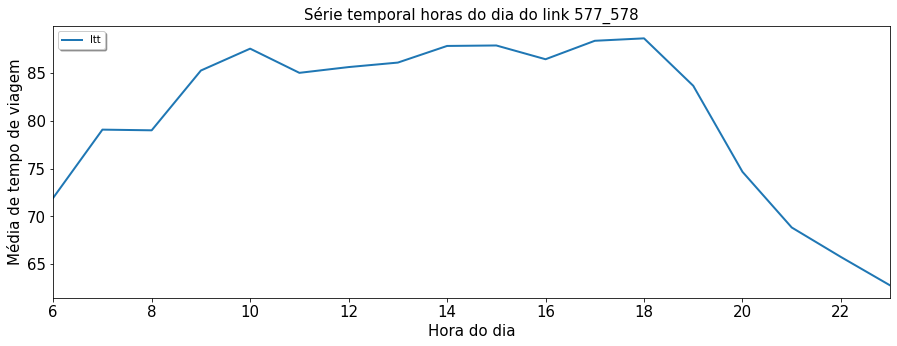

In [130]:
# no_outlier[['ltt', 'day_hour']].groupby(no_outlier['day_hour']).mean()
grafic = no_outlier['ltt'].groupby(no_outlier['day_hour']).mean()
grafic.plot(figsize=(15,5), linewidth=2, fontsize=15, marker = "")
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), shadow=True, ncol=14)
plt.title('Série temporal horas do dia do link '+ '577_578', fontsize=15)
plt.xlabel('Hora do dia', fontsize=15);
plt.ylabel('Média de tempo de viagem', fontsize=15);

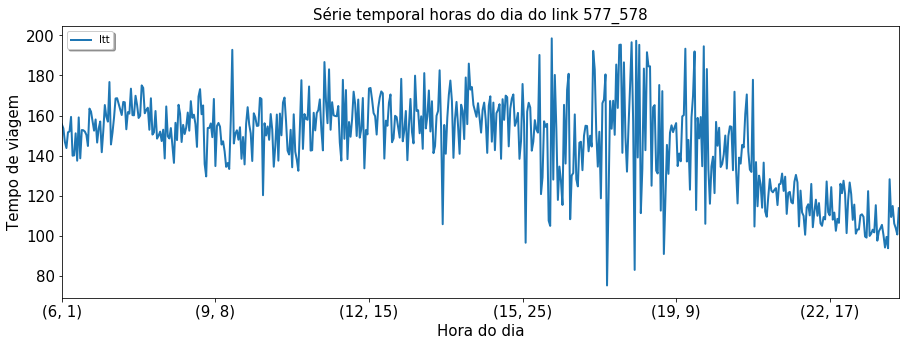

In [131]:
link_577_578_ltt = no_outlier.loc[(no_outlier['link'] == '(577, 578)')]
# link_ltt = no_outlier.loc[(no_outlier['link'] == '(577, 578)')].groupby(['day_hour', 'day'], as_index=True )['ltt'].mean().unstack()

link_ltt = link_577_578_ltt.groupby(['day_hour', 'day'])['ltt'].mean()
link_ltt

link_ltt.plot(figsize=(15,5), linewidth=2, fontsize=15, marker = "")
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), shadow=True, ncol=14)
plt.title('Série temporal horas do dia do link '+ '577_578', fontsize=15)
plt.xlabel('Hora do dia', fontsize=15);
plt.ylabel('Tempo de viagem', fontsize=15);




In [132]:
grafic = pd.DataFrame(grafic).reset_index()
grafic.iloc[1:, 0:]

,day_hour,ltt
1,7,79.092984
2,8,79.021480
3,9,85.288471
4,10,87.579305
5,11,85.044372
6,12,85.648941
7,13,86.119576
8,14,87.863081
9,15,87.912493
10,16,86.469703


In [133]:
# X = link_577_578_ltt.iloc[:1000, 3:4]
# X

# y = link_577_578_ltt.iloc[:1000, 6:7]
# y

y = grafic.iloc[:, 0].values
X = grafic.iloc[:, 1].values
# grafic

X = X.reshape(-1,1)

# scaler_x = StandardScaler()
# X_one = scaler_x.fit_transform(X)

# scaler_y = StandardScaler()
# Y_one = scaler_y.fit_transform(y)

# model_regressor = SVR(kernel='rbf', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_regressor = SVR(kernel = 'rbf', degree=4, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_regressor.fit(X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=4, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [134]:
model_regressor.score(X, y)

0.2481240017634848

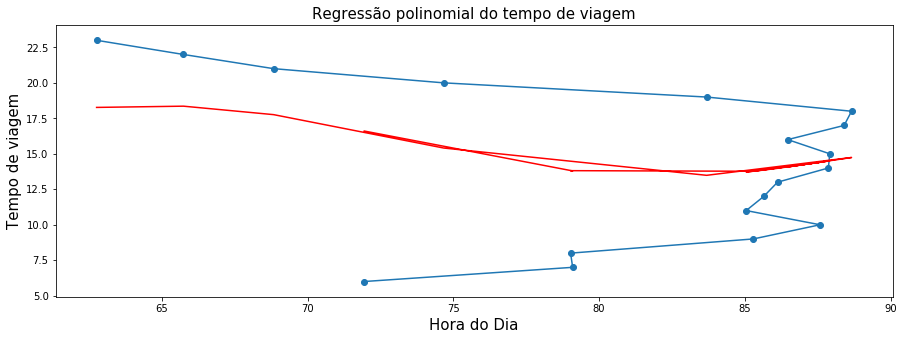

In [135]:

plt.figure(figsize=(15,5))

plt.plot(X, y)
plt.scatter(X, y)

plt.plot(X, model_regressor.predict(X), color='red')
plt.title('Regressão polinomial do tempo de viagem', fontsize=15)
plt.xlabel('Hora do Dia', fontsize=15);
plt.ylabel('Tempo de viagem', fontsize=15);

In [136]:
# X = link_577_578_ltt.iloc[:1000, 3:4]
# X

# y = link_577_578_ltt.iloc[:1000, 6:7]
# y

y_all = no_outlier_577.iloc[:, 0:1]
X_all = no_outlier_577.iloc[:, 1:2]


# scaler_x = StandardScaler()
# X_one = scaler_x.fit_transform(X)

# scaler_y = StandardScaler()
# Y_one = scaler_y.fit_transform(y)

# model_regressor_all = SVR(kernel='rbf')
model_regressor_all = SVR(kernel = 'sigmoid', degree=6, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)
model_regressor_all.fit(X_all, y_all)


/home/roque/env_proj/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=6, epsilon=0.1, gamma='scale',
    kernel='sigmoid', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [137]:
model_regressor_all.score(X, y)

-5972.642291946241

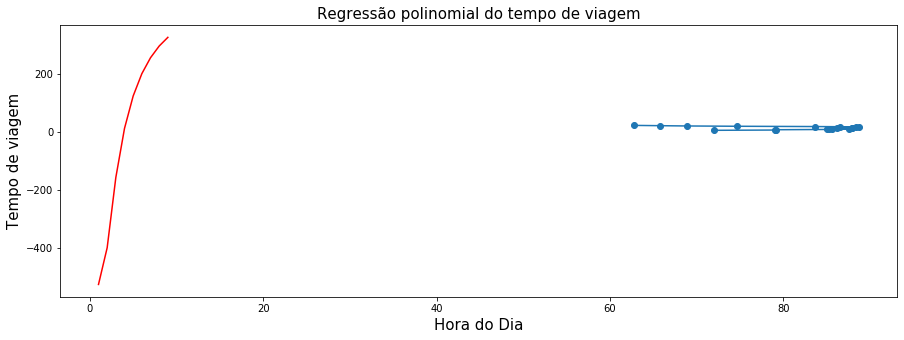

In [138]:
plt.figure(figsize=(15,5))

plt.plot(X, y)
plt.scatter(X, y)

plt.plot(X_all, model_regressor_all.predict(X_all), color='red')
plt.title('Regressão polinomial do tempo de viagem', fontsize=15)
plt.xlabel('Hora do Dia', fontsize=15);
plt.ylabel('Tempo de viagem', fontsize=15);

In [139]:

mod = sm.RecursiveLS(X, y)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   18
Model:                    RecursiveLS   Log Likelihood                 -88.184
Date:                Wed, 24 Jun 2020   R-squared:                       0.853
Time:                        17:41:26   AIC                            178.368
Sample:                             0   BIC                            179.258
                                 - 18   HQIC                           178.491
Covariance Type:            nonrobust   Scale                         1029.563
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             4.8709      0.491      9.918      0.000       3.908       5.833
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 0.65
Prob(Q):                               nan   Pr

[11.99083125 11.59200959 10.85565542 10.36995171  9.88146045  9.30458988
  8.78009635  8.30328773  7.88936975  7.50420453  7.13115726  6.80858745
  6.51154278  6.19659306  5.84658941  5.49869464  5.1738264   4.87085611]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


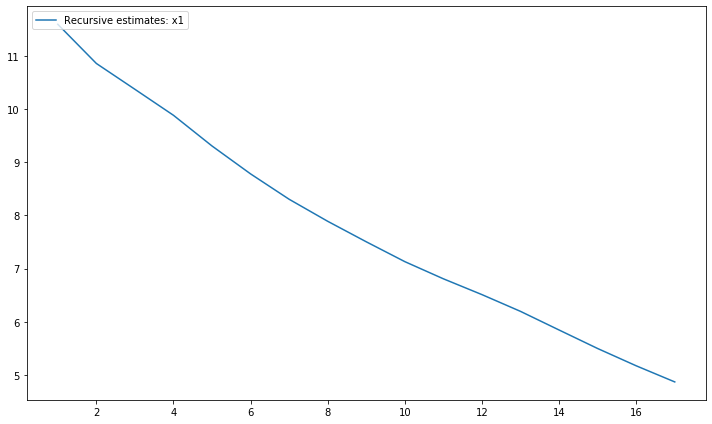

In [140]:
print(res.recursive_coefficients.filtered[0])
print(y)
res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(10,6));

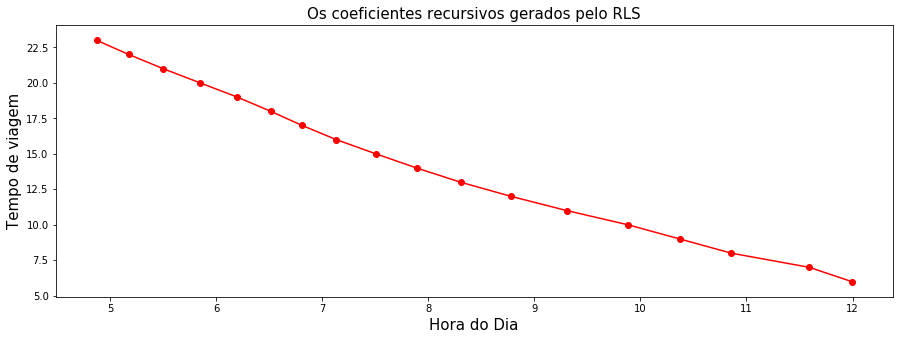

In [141]:
plt.figure(figsize=(15,5))

# plt.plot(X, y)
# plt.scatter(X, y)

plt.plot(res.recursive_coefficients.filtered[0], y, color='red')
plt.scatter(res.recursive_coefficients.filtered[0], y, color='red')
plt.title('Os coeficientes recursivos gerados pelo RLS', fontsize=15)
plt.xlabel('Hora do Dia', fontsize=15);
plt.ylabel('Tempo de viagem', fontsize=15);

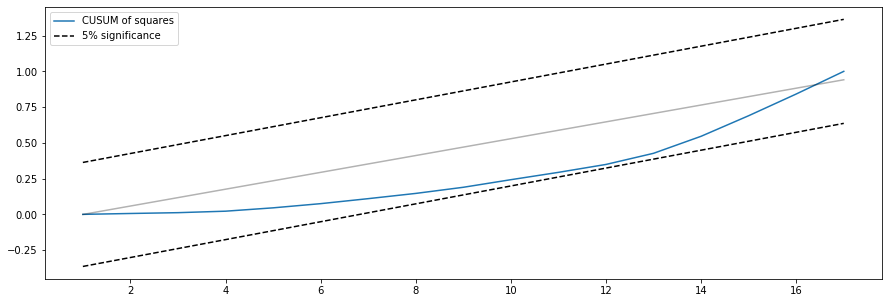

In [142]:
# plt.figure(figsize=(15,5))
res.plot_cusum_squares(figsize=(15,5));


In [143]:

mod_all = sm.RecursiveLS(X_all, y_all)
res_all = mod_all.fit()



/home/roque/env_proj/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


[0.00520177 0.00515102 0.00551639 ... 0.03334346 0.03334957 0.03335427]
[ 6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


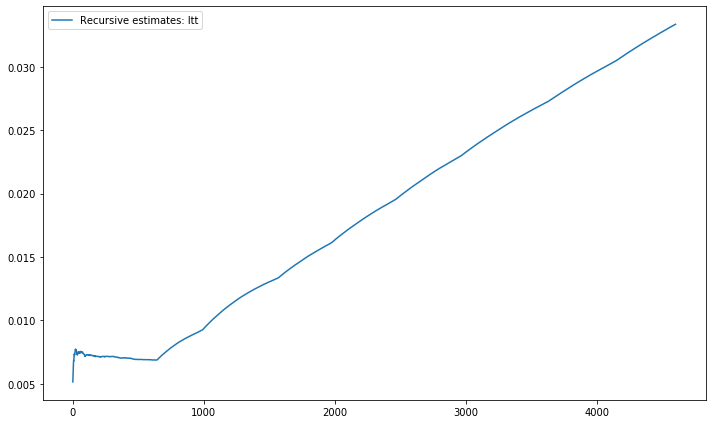

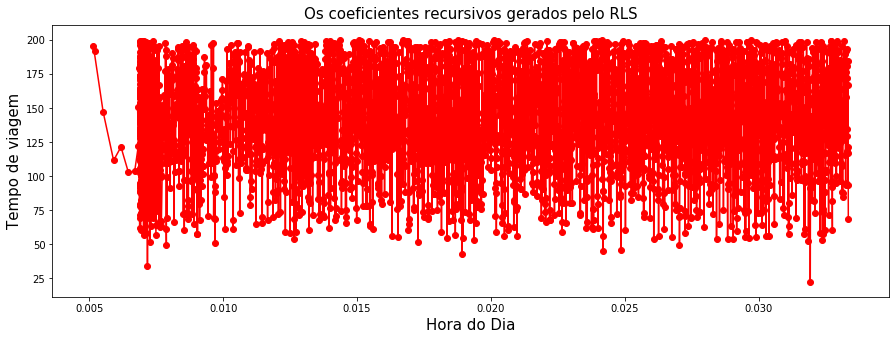

In [144]:
print(res_all.recursive_coefficients.filtered[0])
print(y)
res_all.plot_recursive_coefficient(range(mod_all.k_exog), alpha=None, figsize=(10,6));


plt.figure(figsize=(15,5))

# plt.plot(X, y)
# plt.scatter(X, y)

plt.plot(res_all.recursive_coefficients.filtered[0], y_all, color='red')
plt.scatter(res_all.recursive_coefficients.filtered[0], y_all, color='red')
plt.title('Os coeficientes recursivos gerados pelo RLS', fontsize=15)
plt.xlabel('Hora do Dia', fontsize=15);
plt.ylabel('Tempo de viagem', fontsize=15);

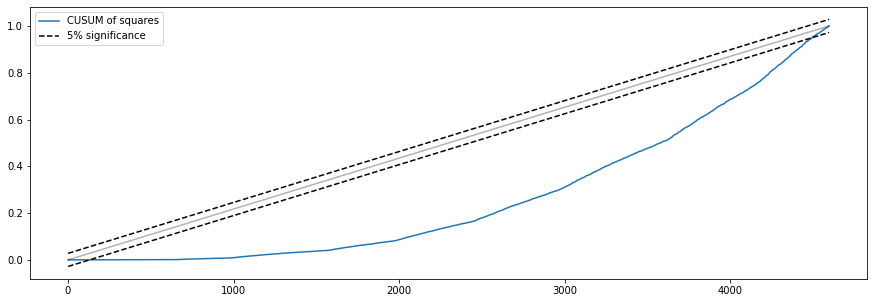

In [145]:
res_all.plot_cusum_squares(figsize=(15,5));

<h3>Usando o padasip com todos os link<hr/>
A matriz de entrada vai ser composta com quatro links vizinhos, dois anteriores e dois poteriores ao link de referência.</h3>

In [146]:
groupedData_semNan

link,aproxlinkstart,"(577, 578)","(578, 579)","(579, 580)","(580, 581)","(581, 582)","(582, 17509)","(582, 17779)","(582, 17933)","(583, 13761)",...,"(787, 788)","(788, 789)","(789, 790)","(790, 791)","(791, 792)","(792, 793)","(792, 4624)","(793, 794)","(794, 4750)","(795, 796)"
940,2017-03-14 06:30:00,164.841288,161.828455,142.193268,84.588066,65.878430,89.758715,96.018930,135.807690,191.675805,...,93.537890,61.180231,61.710855,52.652767,67.021601,64.292624,83.326048,31.649107,31.474190,123.576212
1055,2017-03-23 07:00:00,186.294350,134.052174,116.612505,100.532308,71.682190,85.699997,78.852401,114.400871,149.051569,...,81.104952,53.246584,64.584151,61.676708,65.163811,62.831694,65.675065,27.288692,35.754598,69.948899
1292,2017-04-12 09:00:00,175.400817,131.357179,128.739841,93.362338,71.973442,114.390053,93.949861,130.457196,151.012560,...,93.711378,57.230431,67.645138,48.295329,77.555394,78.976657,111.043142,123.717097,87.235232,77.831873
1463,2017-05-02 07:00:00,198.457496,198.805619,119.011776,101.846517,76.724128,105.042633,106.542519,139.470825,165.410981,...,116.034603,76.543509,53.743176,59.404358,65.966760,58.153932,97.370634,26.595281,33.608428,123.066609
1673,2017-05-19 07:00:00,150.194713,127.411692,149.667735,120.811128,94.443326,128.705337,100.255879,121.516073,126.315636,...,112.329691,72.705078,55.081954,59.475199,75.128612,57.837785,72.880610,30.529605,36.647232,126.098715
1815,2017-05-31 08:30:00,162.440694,135.111481,141.223843,89.509186,78.339454,70.293134,88.922189,189.328512,169.670573,...,110.894951,73.199912,51.212054,44.409720,71.797016,70.586417,128.826119,94.779333,78.541374,105.909134
2628,2017-07-31 06:30:00,154.067005,115.306408,125.861137,95.460753,67.170010,93.425082,85.144374,119.942799,195.658421,...,74.063354,73.419727,52.028871,43.548591,59.470889,41.586947,78.985740,28.710118,26.442012,102.562152
2773,2017-08-09 07:00:00,166.942292,133.353698,148.333080,110.592961,75.676073,89.861390,87.973451,125.247451,114.638629,...,81.265938,71.932965,60.785203,53.459168,66.809133,63.946772,72.910581,32.395293,25.822331,65.640345
3037,2017-09-01 07:00:00,176.170390,152.093092,139.730382,98.314256,71.595945,106.413777,86.876318,127.629844,166.240553,...,68.777959,58.971889,41.381014,58.956189,60.206703,47.569898,119.263784,34.005312,26.403831,78.059702
3255,2017-09-20 06:30:00,170.789282,98.579325,123.728009,82.780121,68.375802,81.506828,94.506644,93.609766,164.853451,...,115.398598,70.573150,50.021937,41.378530,56.799466,60.742014,62.986658,19.318733,23.574272,121.718712


In [147]:
groupedData_semNan['day_hour'] = groupedData_semNan['aproxlinkstart'].apply(hr_func) 
cols = groupedData_semNan.columns.tolist()
cols = cols[-1:] + cols[:-1]
groupedData_semNan = groupedData_semNan[cols]
groupedData_semNan = groupedData_semNan.sort_values(['day_hour'])
groupedData_semNan

/home/roque/env_proj/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


link,day_hour,aproxlinkstart,"(577, 578)","(578, 579)","(579, 580)","(580, 581)","(581, 582)","(582, 17509)","(582, 17779)","(582, 17933)",...,"(787, 788)","(788, 789)","(789, 790)","(790, 791)","(791, 792)","(792, 793)","(792, 4624)","(793, 794)","(794, 4750)","(795, 796)"
940,6,2017-03-14 06:30:00,164.841288,161.828455,142.193268,84.588066,65.878430,89.758715,96.018930,135.807690,...,93.537890,61.180231,61.710855,52.652767,67.021601,64.292624,83.326048,31.649107,31.474190,123.576212
2628,6,2017-07-31 06:30:00,154.067005,115.306408,125.861137,95.460753,67.170010,93.425082,85.144374,119.942799,...,74.063354,73.419727,52.028871,43.548591,59.470889,41.586947,78.985740,28.710118,26.442012,102.562152
3255,6,2017-09-20 06:30:00,170.789282,98.579325,123.728009,82.780121,68.375802,81.506828,94.506644,93.609766,...,115.398598,70.573150,50.021937,41.378530,56.799466,60.742014,62.986658,19.318733,23.574272,121.718712
1055,7,2017-03-23 07:00:00,186.294350,134.052174,116.612505,100.532308,71.682190,85.699997,78.852401,114.400871,...,81.104952,53.246584,64.584151,61.676708,65.163811,62.831694,65.675065,27.288692,35.754598,69.948899
1463,7,2017-05-02 07:00:00,198.457496,198.805619,119.011776,101.846517,76.724128,105.042633,106.542519,139.470825,...,116.034603,76.543509,53.743176,59.404358,65.966760,58.153932,97.370634,26.595281,33.608428,123.066609
1673,7,2017-05-19 07:00:00,150.194713,127.411692,149.667735,120.811128,94.443326,128.705337,100.255879,121.516073,...,112.329691,72.705078,55.081954,59.475199,75.128612,57.837785,72.880610,30.529605,36.647232,126.098715
2773,7,2017-08-09 07:00:00,166.942292,133.353698,148.333080,110.592961,75.676073,89.861390,87.973451,125.247451,...,81.265938,71.932965,60.785203,53.459168,66.809133,63.946772,72.910581,32.395293,25.822331,65.640345
3037,7,2017-09-01 07:00:00,176.170390,152.093092,139.730382,98.314256,71.595945,106.413777,86.876318,127.629844,...,68.777959,58.971889,41.381014,58.956189,60.206703,47.569898,119.263784,34.005312,26.403831,78.059702
1815,8,2017-05-31 08:30:00,162.440694,135.111481,141.223843,89.509186,78.339454,70.293134,88.922189,189.328512,...,110.894951,73.199912,51.212054,44.409720,71.797016,70.586417,128.826119,94.779333,78.541374,105.909134
1292,9,2017-04-12 09:00:00,175.400817,131.357179,128.739841,93.362338,71.973442,114.390053,93.949861,130.457196,...,93.711378,57.230431,67.645138,48.295329,77.555394,78.976657,111.043142,123.717097,87.235232,77.831873


<h3> Vamos usar os links (577, 578), (578,579), (580, 581), e (581, 582) para encontrar o ltt do link (579, 580)</h3>

In [148]:
matriz_entrada = groupedData_semNan.iloc[:, 2:7].drop(columns=['(579, 580)']).values
matriz_entrada

array([[164.84128804, 161.82845528,  84.58806579,  65.87843001],
       [154.06700483, 115.30640801,  95.46075251,  67.1700098 ],
       [170.78928229,  98.57932535,  82.78012067,  68.37580199],
       [186.2943498 , 134.05217432, 100.53230761,  71.68218964],
       [198.45749626, 198.80561923, 101.84651673,  76.72412845],
       [150.19471326, 127.41169161, 120.81112804,  94.44332592],
       [166.94229207, 133.3536977 , 110.59296109,  75.67607294],
       [176.17039045, 152.09309204,  98.31425603,  71.595945  ],
       [162.44069423, 135.11148074,  89.5091858 ,  78.3394543 ],
       [175.40081668, 131.35717883,  93.36233843,  71.97344176]])

In [149]:
matriz_saida = groupedData_semNan.iloc[:, 4].values
matriz_saida

array([142.19326792, 125.86113727, 123.72800941, 116.61250525,
       119.01177621, 149.66773494, 148.33307981, 139.73038224,
       141.22384258, 128.7398408 ])

In [185]:
f = pa.filters.FilterRLS(n=4, mu=0.1, w="random")
y, e, w = f.run(matriz_saida, matriz_entrada)

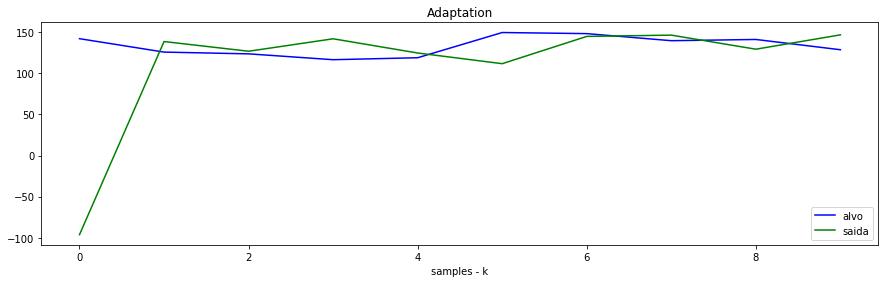

In [186]:
# show results
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(matriz_saida,"b", label="alvo")
plt.plot(y,"g", label="saida");plt.legend()
plt.show()

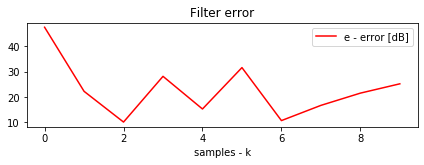

In [187]:
plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10(e**2),"r", label="e - error [dB]");plt.legend()
plt.tight_layout()
plt.show()

In [188]:
e

array([238.40481885, -12.85039316,  -3.16615181, -25.44000561,
        -5.74472602,  37.89068354,   3.38475681,  -6.77155159,
        11.83457595, -18.09393409])

<h3>Agora o mesmo modelo, inserindo a coluna hora e usando o mesmo link de referência</h3>

In [194]:
matriz_entrada_2 = groupedData_semNan.iloc[:, 0:7].drop(columns=['(579, 580)', 'aproxlinkstart']).values
matriz_saida_2 = groupedData_semNan.iloc[:, 4].values

In [239]:
modelo_sec = pa.filters.FilterRLS(n=5, mu=0.1, w="random")
d, p, t = modelo_sec.run(matriz_saida_2, matriz_entrada_2)

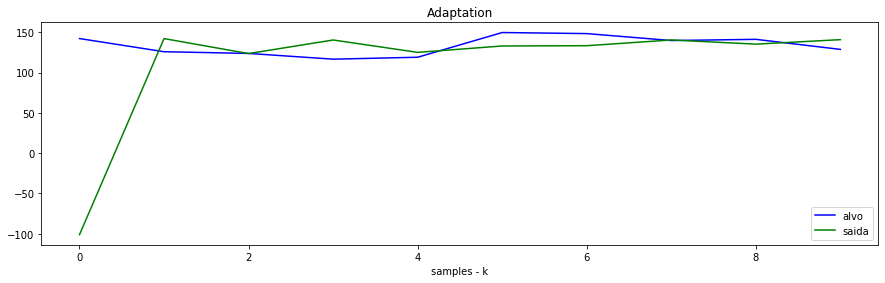

In [240]:
# show results
plt.figure(figsize=(15,9))
plt.subplot(211);plt.title("Adaptation");plt.xlabel("samples - k")
plt.plot(matriz_saida_2,"b", label="alvo")
plt.plot(d,"g", label="saida");plt.legend()
plt.show()

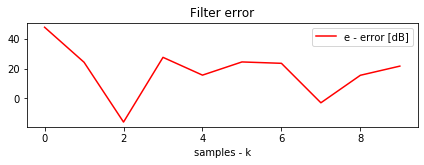

In [241]:
plt.subplot(212);plt.title("Filter error");plt.xlabel("samples - k")
plt.plot(10*np.log10(p**2),"r", label="e - error [dB]");plt.legend()
plt.tight_layout()
plt.show()

In [242]:
p

array([ 2.43332942e+02, -1.62753799e+01,  1.60830961e-01, -2.37982699e+01,
       -6.02945815e+00,  1.66916905e+01,  1.50089543e+01, -7.12326310e-01,
        5.95912577e+00, -1.20892842e+01])

<h2> Agora usando novamente o RecursiveLS, do statsmodels, mas agora com as novas matrizes</h2>

In [154]:
endog = matriz_saida
exog = matriz_entrada
mod = sm.RecursiveLS(endog, exog)
res = mod.fit()

print(res.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                   10
Model:                    RecursiveLS   Log Likelihood                 -46.046
Date:                Wed, 24 Jun 2020   R-squared:                       0.991
Time:                        17:41:38   AIC                            100.092
Sample:                             0   BIC                            101.302
                                 - 10   HQIC                            98.764
Covariance Type:            nonrobust   Scale                          267.161
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1369      0.287      0.477      0.634      -0.426       0.700
x2             0.0148      0.245      0.060      0.952      -0.466       0.496
x3             0.1352      0.772      0.175      0.8

[ 0.36140444  0.37578769  0.36146327 -1.11750802 -1.42888838  0.17150113
  0.14205965  0.14891288  0.14380423  0.13690637]


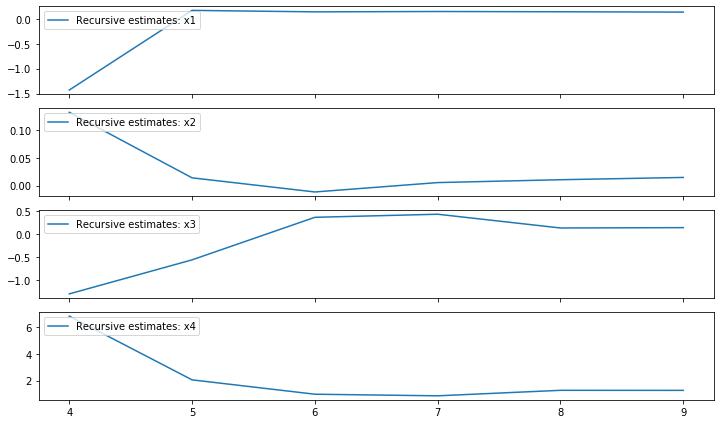

In [155]:
print(res.recursive_coefficients.filtered[0])
res.plot_recursive_coefficient(range(mod.k_exog), alpha=None, figsize=(10,6));

[-1.35683058 -2.72722555 -1.76205077 -1.21121685 -0.79986539 -0.88398392]


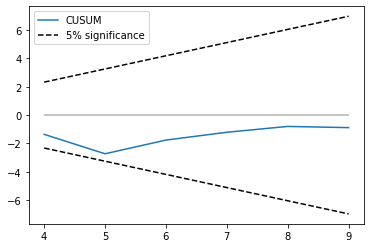

In [156]:
print(res.cusum)
fig = res.plot_cusum()

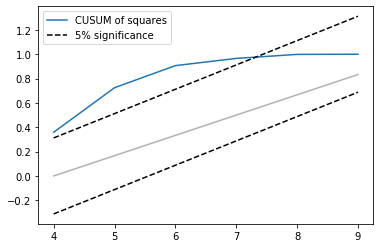

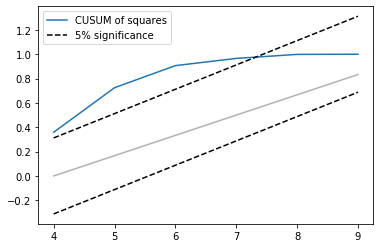

In [157]:
res.plot_cusum_squares()